# Applications
## Dependency analysis on the General registry

https://github.com/JuliaRegistries/General  
Default package registry

Can we get insight on package relations?

# 1 - Who uses LightGraphs?

Tree of packages depending on lightgraphs, directly or transitively.

In [1]:
import Pkg

# change this to your path to General registry repo
path_to_general = joinpath(@__DIR__, "..", "General")
registry_file = Pkg.TOML.parsefile(joinpath(path_to_general, "Registry.toml"))

Dict{String,Any} with 5 entries:
  "name"        => "General"
  "repo"        => "https://github.com/JuliaRegistries/General.git"
  "packages"    => Dict{String,Any}("0efae8bf-39e6-5d65-b05d-c8947f4cee2a"=>Dic…
  "uuid"        => "23338594-aafe-5451-b93e-139f81909106"
  "description" => "Official general Julia package registry where people can\nr…

In [2]:
packages_info = registry_file["packages"];

In [3]:
using LightGraphs
using GraphPlot
using Plots
using MetaGraphs

In [4]:
pkg_paths = map(values(packages_info)) do d
    (name = d["name"], path = d["path"])
end
first(pkg_paths)

(name = "COSMA_jll", path = "C/COSMA_jll")

In [5]:
"""
Find the packages directly depending on a source package.
"""
function find_direct_deps(registry_path, pkg_paths, source)
    filter(pkg_paths) do pkg_path
        deps_file = joinpath(registry_path, pkg_path.path, "Deps.toml")
        isfile(deps_file) && begin
            deps_struct = Pkg.TOML.parsefile(deps_file)
            any(values(deps_struct)) do d
                source in keys(d)
            end
        end
    end
end

find_direct_deps

In [6]:
find_direct_deps(path_to_general, pkg_paths, "LightGraphs")

92-element Array{NamedTuple{(:name, :path),Tuple{String,String}},1}:
 (name = "Mamba", path = "M/Mamba")
 (name = "LightGraphsGraphBLAS", path = "L/LightGraphsGraphBLAS")
 (name = "SimpleWeightedGraphs", path = "S/SimpleWeightedGraphs")
 (name = "QuantumWalk", path = "Q/QuantumWalk")
 (name = "Cookbook", path = "C/Cookbook")
 (name = "PicoQuant", path = "P/PicoQuant")
 (name = "Node2Vec", path = "N/Node2Vec")
 (name = "PorousMaterials", path = "P/PorousMaterials")
 (name = "CombinatorialBandits", path = "C/CombinatorialBandits")
 (name = "ProbabilisticCircuits", path = "P/ProbabilisticCircuits")
 (name = "ModelingToolkit", path = "M/ModelingToolkit")
 (name = "GraphRecipes", path = "G/GraphRecipes")
 (name = "SimpleHypergraphs", path = "S/SimpleHypergraphs")
 ⋮
 (name = "Soss", path = "S/Soss")
 (name = "GridapEmbedded", path = "G/GridapEmbedded")
 (name = "SpectralClustering", path = "S/SpectralClustering")
 (name = "PowerDynamics", path = "P/PowerDynamics")
 (name = "Dispatcher", pat

What is your package? Who uses them?  
How many depend on you? Bets are open!

# Building a directed tree

Directed tree --> all but one vertices have a **unique** outneighbor.  
Starting from root package, add its dependencies, then dependencies of dependencies in breadth-first style.

In [7]:
function build_tree(registry_path, pkg_paths, root)
    g = MetaDiGraph()
    add_vertex!(g)
    set_prop!(g, 1, :name, root)
    i = 1
    explored_nodes = Set{String}((root,))
    while true
        current_node = get_prop(g, i, :name)
        direct_deps = find_direct_deps(registry_path, pkg_paths, current_node)
        filter!(d -> d.name ∉ explored_nodes, direct_deps)
        if isempty(direct_deps) && i >= nv(g)
           break
        end
        for ddep in direct_deps
           push!(explored_nodes, ddep.name)
           add_vertex!(g)
           set_prop!(g, nv(g), :name, ddep.name)
           add_edge!(g, i, nv(g))
        end
        i += 1
    end
    return g
end

build_tree (generic function with 1 method)

In [8]:
g = build_tree(path_to_general, pkg_paths, "LightGraphs")

{230, 229} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [9]:
get_prop.(Ref(g), outneighbors(g, 1), :name)

92-element Array{String,1}:
 "Mamba"
 "LightGraphsGraphBLAS"
 "SimpleWeightedGraphs"
 "QuantumWalk"
 "Cookbook"
 "PicoQuant"
 "Node2Vec"
 "PorousMaterials"
 "CombinatorialBandits"
 "ProbabilisticCircuits"
 "ModelingToolkit"
 "GraphRecipes"
 "SimpleHypergraphs"
 ⋮
 "Soss"
 "GridapEmbedded"
 "SpectralClustering"
 "PowerDynamics"
 "Dispatcher"
 "JuliaGrid"
 "AgentsPlots"
 "Multigraphs"
 "Circuitscape"
 "LightGraphsFlows"
 "PowerModelsAnalytics"
 "ImageSegmentation"

## Tree height?

Shortest path from the root node to any other node:

In [10]:
spath_result = dijkstra_shortest_paths(g, 1)
spath_result.dists

230-element Array{Float64,1}:
 0.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 4.0
 4.0
 4.0
 4.0
 4.0
 5.0
 5.0
 5.0
 5.0
 5.0
 5.0
 6.0

In [11]:
get_prop(g, nv(g), :name)

"NTNk"

## Frontier size

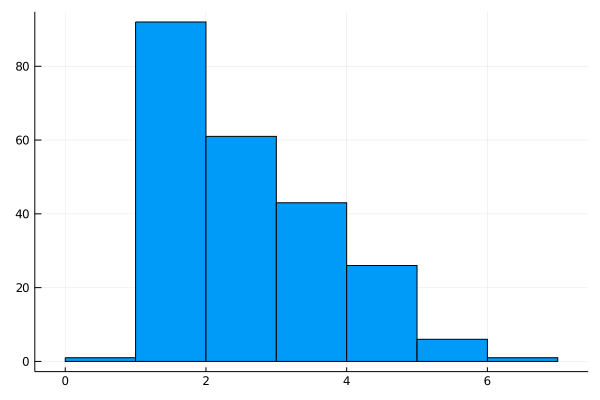

In [12]:
histogram(spath_result.dists, label="")

## Hop-5 from LightGraphs

In [13]:
for idx in eachindex(spath_result.dists)
    if spath_result.dists[idx] == 5
        @info get_prop(g, idx, :name)
    end
end

┌ Info: NTFk
└ @ Main In[13]:3
┌ Info: TransferEntropy
└ @ Main In[13]:3
┌ Info: PerronFrobenius
└ @ Main In[13]:3
┌ Info: CrossMappings
└ @ Main In[13]:3
┌ Info: InteractiveChaos
└ @ Main In[13]:3
┌ Info: TimeseriesSurrogates
└ @ Main In[13]:3


# Computing a full sub-graph

In [14]:
all_packages = get_prop.(Ref(g), vertices(g), :name);
full_graph = MetaDiGraph(length(all_packages))
for v in vertices(full_graph)
    set_prop!(full_graph, v, :name, all_packages[v])
end

In [15]:
for v in vertices(full_graph)
    pkg_name = get_prop(full_graph, v, :name)
    dependent_packages = find_direct_deps(path_to_general, pkg_paths, pkg_name)
    for dep_pkg in dependent_packages
        pkg_idx = findfirst(==(dep_pkg.name), all_packages)
        # only packages in graph
        if pkg_idx !== nothing
            add_edge!(full_graph, pkg_idx, v)
        end
    end
end

In [16]:
full_graph

{230, 412} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

## Which packages matter: centrality

Multiple measures, pick your favorite:  
https://juliagraphs.org/LightGraphs.jl/stable/centrality/

In [17]:
ranks = pagerank(full_graph)
sorted_indices = sort(eachindex(ranks), by=i->ranks[i], rev=true)
get_prop.(Ref(full_graph), sorted_indices, :name)

230-element Array{String,1}:
 "LightGraphs"
 "OrdinaryDiffEq"
 "ModelingToolkit"
 "SparseDiffTools"
 "DiffEqOperators"
 "MetaGraphs"
 "DiffEqCallbacks"
 "VertexSafeGraphs"
 "DifferentialEquations"
 "POMDPs"
 "Mamba"
 "DynamicalSystemsBase"
 "SimpleWeightedGraphs"
 ⋮
 "Molly"
 "Manopt"
 "CurricularVisualization"
 "EntropicCone"
 "ReachabilityAnalysis"
 "RoMEPlotting"
 "RevealedPreferences"
 "PeriodicGraphs"
 "UMAP"
 "OpenSMILES"
 "PkgUtils"
 "NTNk"

## Most dependencies, most depending on

Simple measure: edges in and out

In [18]:
in_sorted_indices = sort(vertices(full_graph), by=i->indegree(full_graph, i) , rev=true)
get_prop.(Ref(full_graph), in_sorted_indices, :name)

230-element Array{String,1}:
 "LightGraphs"
 "OrdinaryDiffEq"
 "DifferentialEquations"
 "MetaGraphs"
 "DiffEqCallbacks"
 "SimpleWeightedGraphs"
 "ModelingToolkit"
 "POMDPs"
 "GraphPlot"
 "StochasticDiffEq"
 "Turing"
 "DynamicalSystemsBase"
 "POMDPModelTools"
 ⋮
 "PkgUtils"
 "QuickPOMDPs"
 "Bio"
 "Molly"
 "Manopt"
 "CurricularVisualization"
 "EntropicCone"
 "ReachabilityAnalysis"
 "RoMEPlotting"
 "FlashWeave"
 "StaticGraphs"
 "NTNk"

In [19]:
out_sorted_indices = sort(vertices(full_graph), by=i->outdegree(full_graph, i) , rev=true)
get_prop.(Ref(full_graph), out_sorted_indices, :name)

230-element Array{String,1}:
 "CausalityTools"
 "DiffEqTutorials"
 "DifferentialEquations"
 "SemanticModels"
 "DiffEqBayes"
 "PowerDynamics"
 "PicoQuant"
 "Petri"
 "Jusdl"
 "Soss"
 "QuickPOMDPs"
 "POMDPModels"
 "POMDPSimulators"
 ⋮
 "StanMamba"
 "PowerModelsAnalytics"
 "LightGraphsFlows"
 "Multigraphs"
 "JuliaGrid"
 "Dispatcher"
 "GridapEmbedded"
 "GraphPlot"
 "ItemGraphs"
 "FractionalGaussianFields"
 "StochOptInterface"
 "LightGraphs"

In [20]:
ranks_betweenness = betweenness_centrality(full_graph)
sorted_indices_betweenness = sort(vertices(full_graph), by=i->ranks_betweenness[i], rev=true)
get_prop.(Ref(full_graph), sorted_indices_betweenness, :name)

230-element Array{String,1}:
 "OrdinaryDiffEq"
 "DifferentialEquations"
 "SparseDiffTools"
 "StochasticDiffEq"
 "DiffEqOperators"
 "ReinforcementLearning"
 "DynamicalSystemsBase"
 "ReinforcementLearningEnvironments"
 "DiffEqSensitivity"
 "Mads"
 "POMDPModels"
 "ChaosTools"
 "ParameterizedFunctions"
 ⋮
 "Jags"
 "Soss"
 "GridapEmbedded"
 "SpectralClustering"
 "PowerDynamics"
 "JuliaGrid"
 "AgentsPlots"
 "Multigraphs"
 "LightGraphsFlows"
 "PowerModelsAnalytics"
 "StanMamba"
 "NTNk"

# Dependencies are Directed Acyclic right?

In [21]:
is_cyclic(full_graph)

true

In [22]:
for cycle in simplecycles(full_graph)
    names = get_prop.(Ref(full_graph), cycle, :name)
    @info names
end

┌ Info: ["StateSpaceRoutines", "DSGE"]
└ @ Main In[22]:3
┌ Info: ["ReinforcementLearningEnvironmentDiscrete", "ReinforcementLearning"]
└ @ Main In[22]:3
